In [1]:
#!pip install optuna
#!pip install jupyterlab-optuna
#!pip install optuna-fast-fanova gunicorn
#!pip install imbalanced-learn
#!pip install hyperopt
#!pip install lightgbm
#!pip install catboost
#!pip install optuna-integration

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import optuna
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import roc_curve, precision_recall_curve, classification_report, log_loss, roc_auc_score, confusion_matrix, recall_score
from IPython.display import Markdown, display
from ipywidgets import widgets, Layout
from IPython import display as disp

# Define a function for printing using markdown
def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

#Bold text delimiters
start_bold = "\033[1m"
end_bold = "\033[0;0m"

In [3]:
#load the dataset and preview the first rows
df = pd.read_csv("./Data/diabetes.csv", sep = ",")

df.head(10)

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   
5            5      116             74              0        0  25.6   
6            3       78             50             32       88  31.0   
7           10      115              0              0        0  35.3   
8            2      197             70             45      543  30.5   
9            8      125             96              0        0   0.0   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
5                     0.201   30        0  
6                     0.248   26        1  
7                     0.134   29        0  
8                     0.158   53        1  
9                     0.232   54        1

# EDA

In [4]:
#Verify that all columns have numeric types
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [5]:
#Check the target variable label values
df["Outcome"].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [6]:
#Get the summary sttistics for all the columns
df.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

In [7]:
# Define a function to extract information about missing measurements 
def print_missing_data_summary():
    '''
    This function will scan for missing values for different features and feature combinations at different steps of the imputation process.

    Symbol dicionary:
    
    N_GLU - Number of missing Glucose measurements 
    N_INS - Number of missing Insulin measurements
    N_BMI - Number of missing BMI measurements
    N_BPS - Number of missing Blood Pressure measurements
    N_STH - Number of missing Skin Thickness measurements
    GL_IN - Number of records missing both glucose and insulin measurements
    BM_IN - Number of records missing both BMI and Insulin data
    BP_IN - Number of records missing both Blood Pressure and Insulin data
    N_BIB - Number of records missing BMI, Insulin, and Blood Pressure measurements
    GI_O1 - Number of records missing Glucose and Insulin measurements while the outcome is positive
    GL_O1 - Number of missing Glucose measurements while the outcome is positive
    IN_O1 - Number of missing Insulin measurements while the outcome is positive    
    '''
    def printmd(string, color=None):
        colorstr = "<span style='color:{}'>{}</span>".format(color, string)
        display(Markdown(colorstr))  
    
    v1 = pd.DataFrame(df[(df["Glucose"] == 0) & (df["Insulin"] == 0)]).shape[0]
    v2 = pd.DataFrame(df[(df["BMI"] == 0) & (df["Insulin"] == 0)]).shape[0]
    v3 = pd.DataFrame(df[(df["BloodPressure"] == 0) & (df["Insulin"] == 0)]).shape[0]
    v4 = pd.DataFrame(df[(df["BMI"] == 0) & (df["Insulin"] == 0) & (df["BloodPressure"] == 0)]).shape[0]
    v5 = pd.DataFrame(df[(df["Glucose"] == 0) & (df["Insulin"] == 0) & (df["Outcome"] == 1)]).shape[0]
    v6 = pd.DataFrame(df[(df["Glucose"] == 0) & (df["Outcome"] == 1)]).shape[0]
    v7 = pd.DataFrame(df[(df["Insulin"] == 0) & (df["Outcome"] == 1)]).shape[0]

    display(Markdown('---'))
    printmd(f"**N_GLU**: {df[df['Glucose'] == 0].shape[0]}", color="#9DC183")
    printmd(f"**N_INS**: {df[df['Insulin'] == 0].shape[0]}", color="#9DC183")
    printmd(f"**N_BMI**: {df[df['BMI'] == 0].shape[0]}", color="#9DC183")
    printmd(f"**N_BPS**: {df[df['BloodPressure'] == 0].shape[0]}", color="#9DC183")
    printmd(f"**N_STH**: {df[df['SkinThickness'] == 0].shape[0]}", color="#9DC183")
    display(Markdown('---'))
    printmd(f"**GL_IN**: {v1}", color="#9DC183")
    printmd(f"**BM_IN**: {v2}", color="#9DC183")
    printmd(f"**BP_IN**: {v3}", color="#9DC183")
    printmd(f"**N_BIB**: {v4}", color="#9DC183")
    printmd(f"**GI_O1**: {v5}", color="#9DC183")
    printmd(f"**GL_O1**: {v6}", color="#9DC183")
    printmd(f"**IN_O1**: {v7}", color="#9DC183")


#Define a function that displays objects such as plots and dataframes sideways (rather than stacked) 
# def render_widgets(num_widgets, titles, objects):
#     # Create output widgets
#     widgets_list = [widgets.Output() for _ in range(num_widgets)]
    
#     # Render content in output widgets
#     for i in range(num_widgets):
#         with widgets_list[i]:
#             disp.display(objects[i].style.set_caption(titles[i]))
    
#     # Add CSS styles to distribute free space
#     box_layout = Layout(display='flex',
#                         flex_flow='row',
#                         justify_content='flex-start',
#                         width='auto'
#                        )
    
#     # Create Horizontal Box container
#     hbox = widgets.HBox(widgets_list, layout=box_layout)
    
#     # Render hbox
#     disp.display(hbox)

def render_widgets(num_widgets, titles, objects):
    # Create output widgets
    widgets_list = [widgets.Output() for _ in range(num_widgets)]
    
    # Render content in output widgets
    for i in range(num_widgets):
        with widgets_list[i]:
            # Display title in bold format
            title_html = "<b>{}</b>".format(titles[i])
            disp.display(disp.HTML(title_html))
            disp.display(objects[i])
    
    # Add CSS styles to distribute free space
    box_layout = Layout(display='flex',
                        flex_flow='row',
                        justify_content='flex-start',
                        width='auto'
                       )
    
    # Create Horizontal Box container
    hbox = widgets.HBox(widgets_list, layout=box_layout)
    
    # Render hbox
    disp.display(hbox)

#Define a function to summarize the classification metrics
def print_classification_metrics(model, x_train, y_train, x_test, y_test):

    #Define pointers for bold text formatting
    start_bold = "\033[1m"
    end_bold = "\033[0m"
    
    #print(start_bold + "Classification metrics" + end_bold)
    print()

    # performance of the trained model on the training set 
    train_result = model.score(x_train, y_train)

    # performance of the trained model using the testing set
    test_result = model.score(x_test, y_test)

    # make predictions on the training data
    y_train_predict = model.predict(x_train)     

    # make predictions on the test data
    y_predict = model.predict(x_test)

    # predict class probabilities on the training set
    y_train_predict_proba = model.predict_proba(x_train)

    # predict class probabilities on the test set
    y_predict_proba = model.predict_proba(x_test)

    # Calculate log loss for the training set
    log_loss_train = round(log_loss(y_train, y_train_predict_proba), 4)
    
    # Calculate log loss for the test set
    log_loss_value = round(log_loss(y_test, y_predict_proba), 4)

    # Calculate ROC AUC for the training set    
    roc_auc_train = roc_auc_score(y_train, y_train_predict_proba[:, 1])

    # Calculate ROC AUC for the test set    
    roc_auc = roc_auc_score(y_test, y_predict_proba[:, 1])

    # Calculate Precision-Recall score for the TRAINING set
    precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_train_predict_proba[:, 1])

    # Define recall levels for interpolation
    recall_levels = np.linspace(0, 1, 100)

    # Interpolate precision values for each recall level
    interp_precision_train = np.interp(recall_levels, recall_train[::-1], precision_train[::-1])

    # Calculate AUPRC using the trapezoidal rule
    auprc_train = np.trapz(interp_precision_train, recall_levels)    
    
    # Calculate Precision-Recall score for the TEST set
    precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_predict_proba[:, 1])

    # # Define recall levels for interpolation
    # recall_levels = np.linspace(0, 1, 100)

    # Interpolate precision values for each recall level
    interp_precision_test = np.interp(recall_levels, recall_test[::-1], precision_test[::-1])

    # Calculate AUPRC using the trapezoidal rule
    auprc_test = np.trapz(interp_precision_test, recall_levels)    

    train_report = pd.DataFrame(classification_report(y_train, 
                                                      y_train_predict,
                                                      digits=4,
                                                      output_dict = True)).transpose().astype(float).round(4).map("{:,.2f}".format)
    
    test_report = pd.DataFrame(classification_report(y_test,
                                                     y_predict,
                                                     digits=4,
                                                     output_dict = True)).transpose().astype(float).round(4).map("{:,.2f}".format)    

    titles = ['Training set performance', 'Test set performance']
    render_widgets(2, titles, [train_report, test_report])

    add_train_metrics = pd.DataFrame([{'Log Loss': log_loss_train,
                                      'ROC AUC': round(roc_auc_train, 4),
                                      'AUPRC': round(auprc_train, 4)}], columns = ['Log Loss',
                                                                                   'ROC AUC',
                                                                                   'AUPRC']).transpose().rename(columns = {0: 'Train Score'})
    add_test_metrics = pd.DataFrame([{'Log Loss': log_loss_value,
                                     'ROC AUC': round(roc_auc, 4),
                                     'AUPRC': round(auprc_test, 4)}], columns = ['Log Loss',
                                                                                 'ROC AUC',
                                                                                 'AUPRC']).transpose().rename(columns = {0: 'Test Score'})

    titles = ['Additional metrics', '(Log Loss, ROC Curve, Precission-Recall)']
    render_widgets(2, titles, [add_train_metrics, add_test_metrics])

    # # print the performance report
    # print(classification_report(y_test, y_predict, digits=4))
    # print()

    # print("Train Accuracy: {}".format(round(train_result, 4)))
    # print()
    
    # print("Test Accuracy: {}".format(round(test_result, 4)))
    # print()

    # recall = recall_score(y_test, y_predict, pos_label=1)
    # print("Positive Recall: {}".format(round(recall, 4)))
    # print()

    # # Calculate log loss
    # log_loss_value = round(log_loss(y_test, y_predict_proba), 4)
    # print("Log Loss: {}".format(log_loss_value))
    # print()

    # # Calculate ROC AUC
    # roc_auc = roc_auc_score(y_test, y_predict_proba[:, 1])
    # print("ROC AUC: {}".format(round(roc_auc, 4)))
    # print()

    # # Calculate Precision-Recall curve
    # precision, recall, thresholds = precision_recall_curve(y_test, y_predict_proba[:, 1])

    # # Define recall levels for interpolation
    # recall_levels = np.linspace(0, 1, 100)

    # # Interpolate precision values for each recall level
    # interp_precision = np.interp(recall_levels, recall[::-1], precision[::-1])

    # # Calculate AUPRC using the trapezoidal rule
    # auprc = np.trapz(interp_precision, recall_levels)

    # print("AUPRC: {}".format(round(auprc, 4)))
    # print()

In [8]:
df.hist(bins = 30, figsize = (10, 10), color = 'orange')

plt.show()

Insights from the histograms:

* There are more young participants.
* Zero values for skin thickness, glucose, insulin, blood presure, and bmi indicate missing measurements. A glucose level of zero would mean the patient is in a coma or worse.
* There are about twice as many patients without diabetes (outcome = 0) than with diabetes (outcome = 1) resulting in unbalanced target classes.     

In [9]:
print_missing_data_summary()

---

<span style='color:#9DC183'>**N_GLU**: 5</span>

<span style='color:#9DC183'>**N_INS**: 374</span>

<span style='color:#9DC183'>**N_BMI**: 11</span>

<span style='color:#9DC183'>**N_BPS**: 35</span>

<span style='color:#9DC183'>**N_STH**: 227</span>

---

<span style='color:#9DC183'>**GL_IN**: 4</span>

<span style='color:#9DC183'>**BM_IN**: 10</span>

<span style='color:#9DC183'>**BP_IN**: 35</span>

<span style='color:#9DC183'>**N_BIB**: 7</span>

<span style='color:#9DC183'>**GI_O1**: 2</span>

<span style='color:#9DC183'>**GL_O1**: 2</span>

<span style='color:#9DC183'>**IN_O1**: 138</span>

* For the two cases where the outcome is positive but the glucose and insulin measurements are missing, a good reasonable value to impute is the mean between the 75th percentile and the maximum value (based on CDC - https://www.cdc.gov/diabetes/managing/manage-blood-sugar.html), as higher values are most likely for positive cases (assuming the labels are accurate).
* For missing inslulin levels (the highest number of missing values) it's a little more complicated as it is not clearly defined what constitudes a normal level and it might be dependent on BMI and other factors. On the other hand, removing 374 records (138 of which  coresspond to the positive class) would not be practical either, as the dataset is imbalanced and not very big as it is. Using the mean and the median is more appropriate in this case.       

In [10]:
df1 = pd.DataFrame(df[df["Outcome"] == 0]["Insulin"]).describe()
df2 = pd.DataFrame(df[df["Outcome"] == 1]["Insulin"]).describe()
df3 = pd.DataFrame(df["Insulin"]).describe()

titles = ['Summary of Insulin (Class 0)', 'Summary of Insulin (Class 1)', 'Summary of Insulin (Total)']
render_widgets(3, titles, [df1, df2, df3])

In [11]:
m = round(pd.DataFrame(df[(df["Insulin"] == 0) & (df["Outcome"] == 1)]).shape[0] / df["Outcome"].value_counts()[1], 3)
printmd(f"The ratio of records with missing insulin measurements to the total number of records in the positive class is: {m}", color = "#9DC183")

<span style='color:#9DC183'>The ratio of records with missing insulin measurements to the total number of records in the positive class is: 0.515</span>

In [12]:
#Visualize the distribution of Insulin measurements
df["Insulin"].hist(bins = 30)

<Axes: >

In [13]:
# 
mean_insulin = int(np.mean(df["Insulin"]))
median_insulin = int(np.median(df["Insulin"]))

df.loc[(df["Outcome"] == 1) & ((df["Insulin"] == 0) | (df["BMI"] > 30)), "Insulin"] = mean_insulin

df.loc[(df["Outcome"] == 0) & (df["Insulin"] == 0), "Insulin"] = median_insulin

In [14]:
df1 = pd.DataFrame(df[df["Outcome"] == 0]["Insulin"]).describe()
df2 = pd.DataFrame(df[df["Outcome"] == 1]["Insulin"]).describe()
df3 = pd.DataFrame(df["Insulin"]).describe()

titles = ['Summary of Insulin (Class 0)', 'Summary of Insulin (Class 1)', 'Summary of Insulin (Total)']
render_widgets(3, titles, [df1, df2, df3])

In [15]:
print(np.median(df[df["Outcome"] == 1]["Insulin"]))

79.0


In [16]:
df["Insulin"].hist(bins = 30)

<Axes: >

In [17]:
print_missing_data_summary()

---

<span style='color:#9DC183'>**N_GLU**: 5</span>

<span style='color:#9DC183'>**N_INS**: 0</span>

<span style='color:#9DC183'>**N_BMI**: 11</span>

<span style='color:#9DC183'>**N_BPS**: 35</span>

<span style='color:#9DC183'>**N_STH**: 227</span>

---

<span style='color:#9DC183'>**GL_IN**: 0</span>

<span style='color:#9DC183'>**BM_IN**: 0</span>

<span style='color:#9DC183'>**BP_IN**: 0</span>

<span style='color:#9DC183'>**N_BIB**: 0</span>

<span style='color:#9DC183'>**GI_O1**: 0</span>

<span style='color:#9DC183'>**GL_O1**: 2</span>

<span style='color:#9DC183'>**IN_O1**: 0</span>

In [18]:
df1 = pd.DataFrame(df[df["Outcome"] == 0]["BMI"]).describe()
df2 = pd.DataFrame(df[df["Outcome"] == 1]["BMI"]).describe()
df3 = pd.DataFrame(df["BMI"]).describe()
df4 = pd.DataFrame(df[df["Outcome"] == 0]["BloodPressure"]).describe()
df5 = pd.DataFrame(df[df["Outcome"] == 1]["BloodPressure"]).describe()
df6 = pd.DataFrame(df["BloodPressure"]).describe()

titles = ['Summary of BMI (Class 0)', 'Summary of BMI (Class 1)', 'Summary of BMI (Total)', 'Summary of Blood Pressure (Class 0)', 'Summary of Blood Pressure (Class 1)', 'Summary of Blood Pressure (Total)']
render_widgets(6, titles, [df1, df2, df3, df4, df5, df6])

In [19]:
df.loc[(df["Outcome"] == 1) & (df["BMI"] == 0), "BMI"] = np.median(df["BMI"][df["Outcome"] == 1])

df.loc[(df["Outcome"] == 0) & (df["BMI"] == 0), "BMI"] = np.median(df["BMI"][df["Outcome"] == 0])

df.loc[(df["Outcome"] == 1) & (df["BloodPressure"] == 0), "BloodPressure"] = int(np.median(df["BloodPressure"][df["Outcome"] == 1]))

df.loc[(df["Outcome"] == 0) & (df["BloodPressure"] == 0), "BloodPressure"] = int(np.median(df["BloodPressure"][df["Outcome"] == 0]))

In [20]:
df1 = pd.DataFrame(df[df["Outcome"] == 0]["BMI"]).describe()
df2 = pd.DataFrame(df[df["Outcome"] == 1]["BMI"]).describe()
df3 = pd.DataFrame(df["BMI"]).describe()
df4 = pd.DataFrame(df[df["Outcome"] == 0]["BloodPressure"]).describe()
df5 = pd.DataFrame(df[df["Outcome"] == 1]["BloodPressure"]).describe()
df6 = pd.DataFrame(df["BloodPressure"]).describe()

titles = ['Summary of BMI (Class 0)', 'Summary of BMI (Class 1)', 'Summary of BMI (Total)', 'Summary of Blood Pressure (Class 0)', 'Summary of Blood Pressure (Class 1)', 'Summary of Blood Pressure (Total)']
render_widgets(6, titles, [df1, df2, df3, df4, df5, df6])

In [21]:
print_missing_data_summary()

---

<span style='color:#9DC183'>**N_GLU**: 5</span>

<span style='color:#9DC183'>**N_INS**: 0</span>

<span style='color:#9DC183'>**N_BMI**: 0</span>

<span style='color:#9DC183'>**N_BPS**: 0</span>

<span style='color:#9DC183'>**N_STH**: 227</span>

---

<span style='color:#9DC183'>**GL_IN**: 0</span>

<span style='color:#9DC183'>**BM_IN**: 0</span>

<span style='color:#9DC183'>**BP_IN**: 0</span>

<span style='color:#9DC183'>**N_BIB**: 0</span>

<span style='color:#9DC183'>**GI_O1**: 0</span>

<span style='color:#9DC183'>**GL_O1**: 2</span>

<span style='color:#9DC183'>**IN_O1**: 0</span>

In [22]:
df1 = pd.DataFrame(df[df["Outcome"] == 0]["Glucose"]).describe()
df2 = pd.DataFrame(df[df["Outcome"] == 1]["Glucose"]).describe()
df3 = pd.DataFrame(df["Glucose"]).describe()
df4 = pd.DataFrame(df[df["Outcome"] == 0]["SkinThickness"]).describe()
df5 = pd.DataFrame(df[df["Outcome"] == 1]["SkinThickness"]).describe()
df6 = pd.DataFrame(df["SkinThickness"]).describe()

titles = ['Summary of Glucose (Class 0)', 'Summary of Glucose (Class 1)', 'Summary of Glucose (Total)', 'Summary of Skin Thickness (Class 0)', 'Summary of Skin Thickness (Class 1)', 'Summary of Skin Thickness (Total)']
render_widgets(6, titles, [df1, df2, df3, df4, df5, df6])

In [23]:
df.loc[(df["Outcome"] == 1) & (df["Glucose"] == 0), "Glucose"] = int(np.median(df["Glucose"][df["Outcome"] == 1]))

df.loc[(df["Outcome"] == 0) & (df["Glucose"] == 0), "Glucose"] = int(np.median(df["Glucose"][df["Outcome"] == 0]))

df.loc[(df["Outcome"] == 1) & (df["SkinThickness"] == 0), "SkinThickness"] = int(np.median(df["SkinThickness"][df["Outcome"] == 1]))

df.loc[(df["Outcome"] == 0) & (df["SkinThickness"] == 0), "SkinThickness"] = int(np.median(df["SkinThickness"][df["Outcome"] == 0]))

In [24]:
df1 = pd.DataFrame(df[df["Outcome"] == 0]["Glucose"]).describe()
df2 = pd.DataFrame(df[df["Outcome"] == 1]["Glucose"]).describe()
df3 = pd.DataFrame(df["Glucose"]).describe()
df4 = pd.DataFrame(df[df["Outcome"] == 0]["SkinThickness"]).describe()
df5 = pd.DataFrame(df[df["Outcome"] == 1]["SkinThickness"]).describe()
df6 = pd.DataFrame(df["SkinThickness"]).describe()

titles = ['Summary of Glucose (Class 0)', 'Summary of Glucose (Class 1)', 'Summary of Glucose (Total)', 'Summary of Skin Thickness (Class 0)', 'Summary of Skin Thickness (Class 1)', 'Summary of Skin Thickness (Total)']
render_widgets(6, titles, [df1, df2, df3, df4, df5, df6])

In [25]:
print_missing_data_summary()

---

<span style='color:#9DC183'>**N_GLU**: 0</span>

<span style='color:#9DC183'>**N_INS**: 0</span>

<span style='color:#9DC183'>**N_BMI**: 0</span>

<span style='color:#9DC183'>**N_BPS**: 0</span>

<span style='color:#9DC183'>**N_STH**: 0</span>

---

<span style='color:#9DC183'>**GL_IN**: 0</span>

<span style='color:#9DC183'>**BM_IN**: 0</span>

<span style='color:#9DC183'>**BP_IN**: 0</span>

<span style='color:#9DC183'>**N_BIB**: 0</span>

<span style='color:#9DC183'>**GI_O1**: 0</span>

<span style='color:#9DC183'>**GL_O1**: 0</span>

<span style='color:#9DC183'>**IN_O1**: 0</span>

In [26]:
df.hist(bins = 30, figsize = (10, 10), color = 'orange')

plt.show()

In [27]:
# Check the number of records left after cleaning
df.shape

(768, 9)

In [28]:
# Create a correlation matrix

corr_matrix = df.corr()

corr_matrix

Pregnancies   Glucose  BloodPressure  SkinThickness  \
Pregnancies                  1.000000  0.130155       0.209155       0.044593   
Glucose                      0.130155  1.000000       0.224684       0.215366   
BloodPressure                0.209155  0.224684       1.000000       0.159653   
SkinThickness                0.044593  0.215366       0.159653       1.000000   
Insulin                     -0.062114  0.242102      -0.023694       0.145005   
BMI                          0.023887  0.236225       0.285945       0.573227   
DiabetesPedigreeFunction    -0.033523  0.138353      -0.001336       0.144541   
Age                          0.544341  0.268910       0.325306       0.063847   
Outcome                      0.221898  0.495990       0.173316       0.282844   

                           Insulin       BMI  DiabetesPedigreeFunction  \
Pregnancies              -0.062114  0.023887                 -0.033523   
Glucose                   0.242102  0.236225                  0.138353   
BloodPressure            -0.023694  0.285945                 -0.001336   
SkinThickness             0.145005  0.573227                  0.144541   
Insulin                   1.000000  0.156156                  0.160773   
BMI                       0.156156  1.000000                  0.152779   
DiabetesPedigreeFunction  0.160773  0.152779                  1.000000   
Age                      -0.074775  0.027873                  0.033561   
Outcome                   0.015423  0.315606                  0.173844   

                               Age   Outcome  
Pregnancies               0.544341  0.221898  
Glucose                   0.268910  0.495990  
BloodPressure             0.325306  0.173316  
SkinThickness             0.063847  0.282844  
Insulin                  -0.074775  0.015423  
BMI                       0.027873  0.315606  
DiabetesPedigreeFunction  0.033561  0.173844  
Age                       1.000000  0.238356  
Outcome                   0.238356  1.000000

In [29]:
# Plot the correlation matrix
sns.set_context('talk')

plt.figure(figsize = (10, 10))

_ = sns.heatmap(corr_matrix, annot = True, fmt = ".3f", linewidths = .5)

plt.show()

fig = _.get_figure()

fig.savefig('img/corr_mat_diabetes.png')

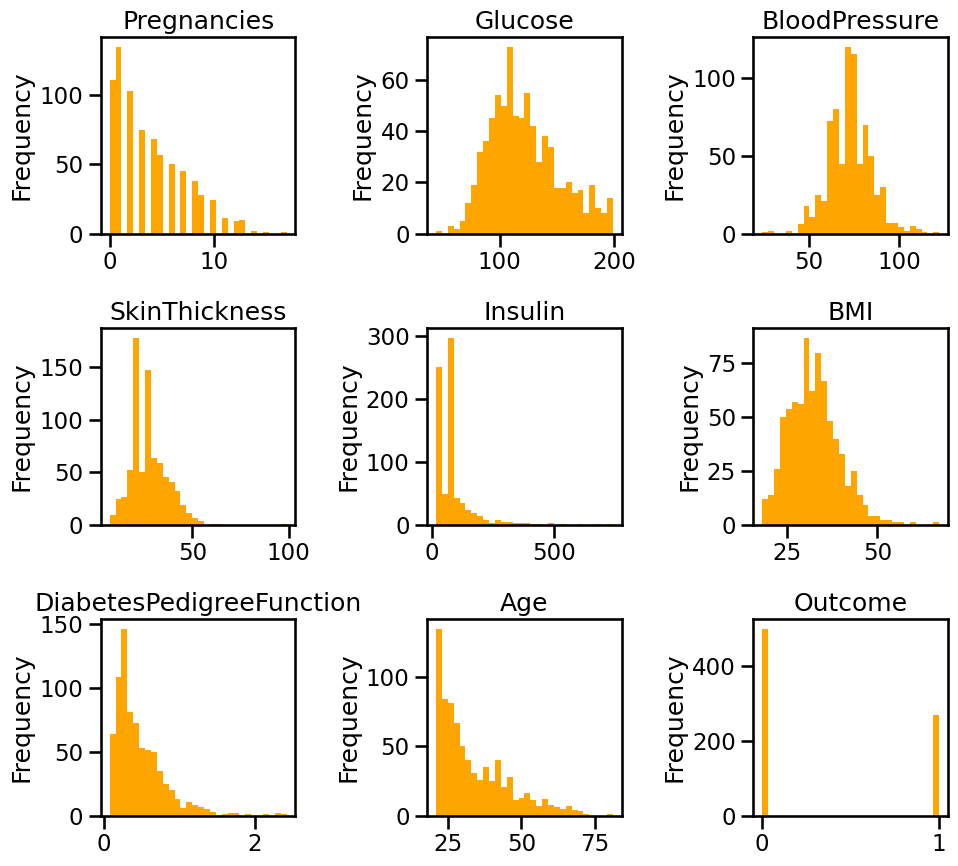

In [30]:
## Export the histograms to an image file
# Determine the number of rows and columns for subplots
num_cols = 3
num_rows = -(-len(df.columns) // num_cols)  # Ceiling division to ensure enough rows

# Create a figure and axes
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 3*num_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot histogram for each column
for i, (col, ax) in enumerate(zip(df.columns, axes)):
    df[col].plot(kind='hist', bins=30, ax=ax, color='orange')
    ax.set_title(col)

# Remove any extra empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('img/histograms_diabetes.png')

# Show the plot
plt.show()

# Split the data into training and test sets

In [31]:
# split the dataframe into target and features

y = df["Outcome"] # target
X = df.drop(columns = ["Outcome"]) # features

# Verify that the split was performed correctly
print(X.shape)
print(y.shape)

(768, 8)
(768,)


In [32]:
from collections import Counter

counter = Counter(y)
print(counter)

Counter({0: 500, 1: 268})


In [33]:
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 1.866


In [34]:
# split the labels and features into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 21, stratify = y)

# Verify that the split was performed correctly
print('Training set')
print(X_train.shape)
print(y_train.shape)
print()
print('Testing set')
print(X_test.shape)
print(y_test.shape)
print()

Training set
(537, 8)
(537,)

Testing set
(231, 8)
(231,)



In [35]:
# Verify that the index has been shuffled
print(X.index)
print()
print(X_train.index)

RangeIndex(start=0, stop=768, step=1)

Index([452, 338, 294, 376, 702, 250, 329, 528, 309, 744,
       ...
       399, 758, 570, 761, 739, 319, 443, 508, 470, 727],
      dtype='int64', length=537)


In [36]:
from sklearn.preprocessing import RobustScaler

# Create a StandardScaler object
scaler = RobustScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data (using the same scaling parameters as the training data)
X_test_scaled = scaler.transform(X_test)

display(pd.DataFrame(X_train_scaled).head())

print()

display(X_train.head())

0         1         2         3         4         5         6         7
0 -0.6 -0.595238 -0.400000  0.454545  2.673469  0.836957  0.035135 -0.294118
1  1.2  0.857143  0.266667  0.636364  0.000000  0.217391  1.418919  0.176471
2 -0.6  1.071429 -1.600000 -0.545455 -1.000000 -1.119565 -0.308108  2.058824
3 -0.6 -0.428571  0.533333 -1.090909  0.102041 -0.760870 -0.186486 -0.470588
4 -0.4  1.238095  0.933333  0.181818  0.000000  0.304348  1.451351  1.294118

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
452            0       91             68             32      210  39.9   
338            9      152             78             34       79  34.2   
294            0      161             50             21       30  21.9   
376            0       98             82             15       84  25.2   
702            1      168             88             29       79  35.0   

     DiabetesPedigreeFunction  Age  
452                     0.381   25  
338                     0.893   33  
294                     0.254   65  
376                     0.299   22  
702                     0.905   52

# Train an XGBoost Classifier in scikit-learn

In [37]:
# import the classifier

from xgboost import XGBClassifier

In [38]:
xgb_classifier = XGBClassifier(objective = 'binary:logistic', 
                               eval_metric = 'logloss', 
                               learning_rate = 0.1,
                               max_depth = 8,
                               #alpha = 25,
                               n_estimators = 100,
                               scale_pos_weight=1.908
                               )

xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

# Test the model

In [39]:
print_classification_metrics(xgb_classifier, X_train, y_train, X_test, y_test)

In [40]:
# print the confusion matrix
cm = confusion_matrix(y_test, xgb_classifier.predict(X_test))

sns.set_context('talk')

sns.heatmap(cm, fmt = 'd', annot = True, cmap = 'RdGy')

plt.savefig('img/conf_mat_diabetes.png')


## Re-train the model on the scaled set

In [40]:
xgb_classifier.fit(X_train_scaled, y_train)

# predict the performance score of the trained model using the testing dataset

print_classification_metrics(xgb_classifier, X_train_scaled, y_train, X_test_scaled, y_test)

# Define the confusion matrix
cm = confusion_matrix(y_test, xgb_classifier.predict(X_test_scaled))

sns.set_context('talk')

sns.heatmap(cm, fmt = 'd', annot = True, cmap = 'RdGy')

plt.savefig('img/conf_mat_diabetes.png')

In [42]:
X_train = X_train.drop(columns = "DiabetesPedigreeFunction") 
X_test = X_test.drop(columns = "DiabetesPedigreeFunction") 

In [43]:
selected_features = SelectKBest(chi2, k = 6).fit(X_train, y_train)

print('Score List: ', selected_features.scores_)
print()
print('Feature list: ', X_train.columns)

Score List:  [  72.39269054 1056.28510092   36.86501511  146.58377717   14.00526778
   87.23393299  122.69623688]

Feature list:  Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'Age'],
      dtype='object')


In [46]:
X_train_2 = selected_features.transform(X_train)

X_test_2 = selected_features.transform(X_test)

xgb_classifier_2 = XGBClassifier(objective = 'binary:logistic', 
                                 eval_metric = 'logloss', 
                                 learning_rate = 0.02,
                                 max_depth = 8,
                                 alpha = 17,
                                 n_estimators = 230,                
                                 min_child_weight = 1,                                 
                                 scale_pos_weight = 1.908,
                                 use_label_encoder = False,
                                 seed = 21).fit(X_train_2, y_train, verbose = 0)

In [47]:
print_classification_metrics(xgb_classifier_2, X_test_2, y_test)

Classification metrics

              precision    recall  f1-score   support

           0     0.8707    0.8533    0.8620       150
           1     0.7381    0.7654    0.7515        81

    accuracy                         0.8225       231
   macro avg     0.8044    0.8094    0.8067       231
weighted avg     0.8242    0.8225    0.8232       231

Accuracy: 0.8225

Positive Recall: 0.7654

Log Loss: 0.4453

ROC AUC: 0.8894

AUPRC: 0.7865



In [48]:
cm_2 = confusion_matrix(y_test, xgb_classifier_2.predict(X_test_2))

sns.heatmap(cm_2, annot = True, fmt = 'd')

<Axes: >

In [49]:
display(pd.DataFrame(X_train_2).head())
display(X_train.head())

0      1     2     3     4     5
0  0.0   91.0  68.0  32.0  39.9  25.0
1  9.0  152.0  78.0  34.0  34.2  33.0
2  0.0  161.0  50.0  21.0  21.9  65.0
3  0.0   98.0  82.0  15.0  25.2  22.0
4  1.0  168.0  88.0  29.0  35.0  52.0

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  Age
452            0       91             68             32      210  39.9   25
338            9      152             78             34       79  34.2   33
294            0      161             50             21       30  21.9   65
376            0       98             82             15       84  25.2   22
702            1      168             88             29       79  35.0   52

In [47]:
# stratified k-fold cross validation evaluation of xgboost model
import xgboost
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

# CV model
model = xgboost.XGBClassifier(objective = 'binary:logistic', 
                                 eval_metric = 'logloss', 
                                 learning_rate = 0.0045,
                                 max_depth = 10,
                                 alpha = 17,
                                 n_estimators = 200,                
                                 min_child_weight = 1,                                 
                                 scale_pos_weight = 1.853,
                                 use_label_encoder = False,
                                 seed = 21)
kfold = StratifiedKFold(n_splits=15, shuffle = True, random_state=21)
results = cross_val_score(model, X_train, y_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 97.76% (2.53%)


In [48]:
xgb_classifier_3 = XGBClassifier(objective = 'binary:logistic', 
                                 eval_metric = 'logloss', 
                                 learning_rate = 0.0045,
                                 max_depth = 10,
                                 alpha = 17,
                                 n_estimators = 200,                
                                 min_child_weight = 1,                                 
                                 scale_pos_weight = 1.853,
                                 use_label_encoder = False,
                                 seed = 21
                               )

xgb_classifier_3.fit(X_train, y_train)

# predict the performance score of the trained model using the testing dataset

result3 = xgb_classifier_3.score(X_test, y_test)

y_pred_3 = xgb_classifier_3.predict(X_test)


              precision    recall  f1-score   support

           0       0.94      0.99      0.97       150
           1       0.99      0.89      0.94        81

    accuracy                           0.96       231
   macro avg       0.96      0.94      0.95       231
weighted avg       0.96      0.96      0.96       231


Accuracy: 0.9567

Log Loss: 0.3504

ROC AUC: 0.9798



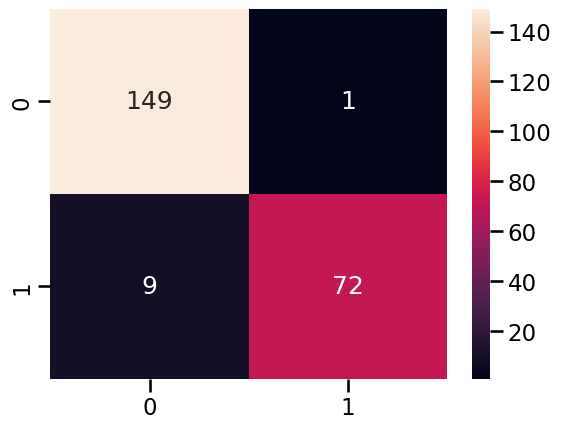

In [49]:
cm_3 = confusion_matrix(y_test, y_pred_3)

sns.heatmap(cm_3, annot = True, fmt = 'd')

print()
print(classification_report(y_test, y_pred_3))

print()
print("Accuracy: {}".format(round(result3, 4)))

print()
# Calculate log loss
log_loss_3 = log_loss(y_test, xgb_classifier_3.predict_proba(X_test))

print("Log Loss: {}".format(round(log_loss_3, 4)))

print()

# Calculate ROC AUC
roc_auc_3 = roc_auc_score(y_test, xgb_classifier_3.predict_proba(X_test)[:, 1])

print("ROC AUC: {}".format(round(roc_auc_3, 4)))

print()

In [50]:
df_less_features = df.drop(columns = ["DiabetesPedigreeFunction"])

# split data into X and y
y_less = df_less_features["Outcome"] # target
X_less = df_less_features.drop(columns = ["Outcome"]) # features

X_less_train, X_less_test, y_less_train, y_less_test = train_test_split(X_less, y_less, test_size = 0.23, random_state = 21, stratify = y)

selected_features = SelectKBest(chi2, k = 6).fit(X_less_train, y_less_train)

print()
print('Score List: ', selected_features.scores_)
print()
print('Feature list: ', X_train.columns)
print()
X_train_4 = selected_features.transform(X_less_train)

X_test_4 = selected_features.transform(X_less_test)

#Compare the transformed and original array
print("Reduced features array")

display(pd.DataFrame(X_train_4).head())

print()
print("Original training set")

display(pd.DataFrame(X_less_train).head())



Score List:  [  73.26705568 1133.453192     35.58452494  157.98292606   14.51321865
   92.68393996  128.83147192]

Feature list:  Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'Age'],
      dtype='object')

Reduced features array


0      1     2     3     4     5
0  14.0  100.0  78.0  25.0  36.6  46.0
1  12.0  106.0  80.0  21.0  23.6  44.0
2   2.0  110.0  74.0  29.0  32.4  27.0
3  10.0  122.0  68.0  21.0  31.2  41.0
4   1.0  102.0  74.0  27.0  39.5  42.0


Original training set


Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  Age
298           14      100             78             25       79  36.6   46
333           12      106             80             21       30  23.6   44
85             2      110             74             29      125  32.4   27
246           10      122             68             21       30  31.2   41
739            1      102             74             27       79  39.5   42

In [51]:
#Return the transformed arrays to a dataframe with the corresponding column names to keep consistent with the test set
X_train_4 = pd.DataFrame(X_train_4, columns = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "BMI", "Age"])
X_test_4 = pd.DataFrame(X_test_4, columns = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "BMI", "Age"])

In [52]:
xgb_classifier_4 = XGBClassifier(objective = 'binary:logistic',                                   
                                 learning_rate = 0.0045,
                                 max_depth = 10,
                                 alpha = 17,
                                 n_estimators = 200,                
                                 min_child_weight = 1,                                 
                                 scale_pos_weight = 1.853,
                                 use_label_encoder = False,
                                 seed = 21).fit(X_train_4, y_less_train, verbose = 0)

result4 = xgb_classifier_4.score(X_test_4, y_less_test)

y_pred_4 = xgb_classifier_4.predict(X_test_4) 

y_pred_proba_4 = xgb_classifier_4.predict_proba(X_test_4)

In [53]:
# cm_4 = confusion_matrix(y_less_test, y_pred_4)

# sns.heatmap(cm_4, annot = True, fmt = 'd')

print()
print(classification_report(y_less_test, y_pred_4, digits = 4))

print()
print("Accuracy: {}".format(round(result4, 4)))

print()
# Calculate log loss
log_loss_4 = log_loss(y_less_test, y_pred_proba_4)

print("Log Loss: {}".format(round(log_loss_4, 4)))

print()

# Calculate ROC AUC
roc_auc_4 = roc_auc_score(y_less_test, y_pred_proba_4[:, 1])

print("ROC AUC: {}".format(round(roc_auc_4, 4)))

print()

# Calculate Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_less_test, y_pred_proba_4[:, 1])

# Define recall levels for interpolation
recall_levels = np.linspace(0, 1, 100)

# Interpolate precision values for each recall level
interp_precision = np.interp(recall_levels, recall[::-1], precision[::-1])

# Calculate AUPRC using the trapezoidal rule
auprc = np.trapz(interp_precision, recall_levels)

print("AUPRC: {}".format(round(auprc, 4)))

print()


              precision    recall  f1-score   support

           0     0.8829    0.8522    0.8673       115
           1     0.7424    0.7903    0.7656        62

    accuracy                         0.8305       177
   macro avg     0.8127    0.8212    0.8164       177
weighted avg     0.8337    0.8305    0.8317       177


Accuracy: 0.8305

Log Loss: 0.5399

ROC AUC: 0.8804

AUPRC: 0.7776



In [54]:
from sklearn.model_selection import StratifiedKFold

# Create a StratifiedKFold object with 3 splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)

X_train_4 = pd.DataFrame(X_train_4)

def strat_objective(trial):    
    # Define the hyperparameter search space
    max_depth = trial.suggest_int('max_depth', 3, 10)
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    learning_rate = trial.suggest_float('learning_rate', 0.0, 5e-1, log=False)
    max_leaves = trial.suggest_int('max_leaves', 0, 64)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)    
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    reg_alpha = trial.suggest_float('reg_alpha', 1e-8, 100, log=False)
    reg_lambda = trial.suggest_float('reg_lambda', 1e-8, 100, log=False)
    scale_pos_weight = trial.suggest_float('scale_pos_weight', 1.853, 1.870)  

    # Create the XGBClassifier with the sampled hyperparameters
    classifier = XGBClassifier(
        max_depth = max_depth,
        n_estimators = n_estimators,
        learning_rate = learning_rate,
        max_leaves = max_leaves,
        min_child_weight=min_child_weight,        
        subsample = subsample,
        colsample_bytree = colsample_bytree,
        reg_alpha = reg_alpha,
        reg_lambda = reg_lambda,
        scale_pos_weight = scale_pos_weight,
        objective = 'binary:logistic',        
        grow_policy = 'lossguide',
        use_label_encoder = False,
        seed = 21,
        n_jobs = -1,        
    )
    
    scores = cross_val_score(classifier, X_train_4, y_less_train, cv=skf, scoring='neg_log_loss', verbose = False, n_jobs=-1)
    return -scores.mean()

# Create an Optuna study
study = optuna.create_study(direction='minimize')

# Optimize the objective function
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(strat_objective, n_trials=100, timeout = 600, show_progress_bar = True)

[I 2024-04-27 03:47:55,086] A new study created in memory with name: no-name-f0f8e5c3-fc01-4c6d-a508-dd8f998dc489


  0%|          | 0/100 [00:00<?, ?it/s]

In [55]:
# Print the best hyperparameters and the corresponding score
print()
print('Best hyperparameters: ', study.best_params)
print()
print('Best score (Minimum loss): ', study.best_value)
print()


Best hyperparameters:  {'max_depth': 3, 'n_estimators': 186, 'learning_rate': 0.2339397434664296, 'max_leaves': 59, 'min_child_weight': 1, 'subsample': 0.9985500202256661, 'colsample_bytree': 0.7022402448149299, 'reg_alpha': 2.799687377154972, 'reg_lambda': 42.24531121863919, 'scale_pos_weight': 1.8684627298901}

Best score (Minimum loss):  0.3952462272475493



In [56]:
best_params = study.best_params
xgb_classifier_opt = XGBClassifier(**best_params,
                                   objective = 'binary:logistic',
                                   grow_policy = 'lossguide',
                                   use_label_encoder = False,
                                   seed = 21,
                                   n_jobs = -1).fit(X_train_4, y_less_train, verbose = 0)

result_opt = xgb_classifier_opt.score(X_test_4, y_less_test)

y_pred_opt = xgb_classifier_opt.predict(X_test_4) 

y_pred_proba_opt = xgb_classifier_opt.predict_proba(X_test_4)

In [57]:

print()
print(classification_report(y_less_test, y_pred_opt))

print()
print("Accuracy: {}".format(round(result_opt, 4)))

print()
# Calculate log loss
log_loss_opt = log_loss(y_less_test, y_pred_proba_opt)

print("Log Loss: {}".format(round(log_loss_opt, 4)))

print()

# Calculate ROC AUC
roc_auc_opt = roc_auc_score(y_less_test, y_pred_proba_opt[:, 1])

print("ROC AUC: {}".format(round(roc_auc_opt, 4)))

print()

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_less_test, y_pred_proba_opt[:, 1])

# Calculate Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_less_test, y_pred_proba_opt[:, 1])

# Define recall levels for interpolation
recall_levels = np.linspace(0, 1, 100)

# Interpolate precision values for each recall level
interp_precision_opt = np.interp(recall_levels, recall[::-1], precision[::-1])

# Calculate AUPRC using the trapezoidal rule
auprc_opt = np.trapz(interp_precision_opt, recall_levels)

print("AUPRC: {}".format(round(auprc_opt, 4)))

print()


              precision    recall  f1-score   support

           0       0.88      0.87      0.87       115
           1       0.76      0.77      0.77        62

    accuracy                           0.84       177
   macro avg       0.82      0.82      0.82       177
weighted avg       0.84      0.84      0.84       177


Accuracy: 0.8362

Log Loss: 0.3672

ROC AUC: 0.9125

AUPRC: 0.8115



In [58]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train_4, y_less_train)

xgb_classifier_resampled = XGBClassifier(**best_params,
                                         objective = 'binary:logistic',
                                         grow_policy = 'lossguide',
                                         use_label_encoder = False,
                                         seed = 21,
                                         n_jobs = -1).fit(X_resampled, y_resampled, verbose = 0)

result_resampled = xgb_classifier_resampled.score(X_test_4, y_less_test)

y_pred_resampled = xgb_classifier_resampled.predict(X_test_4) 

y_pred_proba_resampled = xgb_classifier_resampled.predict_proba(X_test_4)

print()
print(classification_report(y_less_test, y_pred_resampled))

print()
print("Accuracy: {}".format(round(result_resampled, 4)))

print()
# Calculate log loss
log_loss_resampled = log_loss(y_less_test, y_pred_proba_resampled)

print("Log Loss: {}".format(round(log_loss_resampled, 4)))

print()

# Calculate ROC AUC
roc_auc_resampled = roc_auc_score(y_less_test, y_pred_proba_resampled[:, 1])

print("ROC AUC: {}".format(round(roc_auc_resampled, 4)))

print()

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_less_test, y_pred_proba_resampled[:, 1])

# Calculate Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_less_test, y_pred_proba_resampled[:, 1])

# Define recall levels for interpolation
recall_levels = np.linspace(0, 1, 100)

# Interpolate precision values for each recall level
interp_precision = np.interp(recall_levels, recall[::-1], precision[::-1])

# Calculate AUPRC using the trapezoidal rule
auprc = np.trapz(interp_precision, recall_levels)

print("AUPRC: {}".format(round(auprc, 4)))


              precision    recall  f1-score   support

           0       0.94      0.82      0.87       115
           1       0.73      0.90      0.81        62

    accuracy                           0.85       177
   macro avg       0.83      0.86      0.84       177
weighted avg       0.87      0.85      0.85       177


Accuracy: 0.8475

Log Loss: 0.3885

ROC AUC: 0.9151

AUPRC: 0.8043


In [59]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

# Create a StratifiedKFold object with 3 splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)

# Define the objective function to optimize
def objective(trial):    
    # Define the hyperparameter search space
    max_depth = trial.suggest_int('max_depth', 3, 10)
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    learning_rate = trial.suggest_float('learning_rate', 0.0, 5e-1, log=False)
    max_leaves = trial.suggest_int('max_leaves', 0, 64)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)    
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    reg_alpha = trial.suggest_float('reg_alpha', 1e-8, 100, log=False)
    reg_lambda = trial.suggest_float('reg_lambda', 1e-8, 100, log=False)
    

    # Create the XGBClassifier with the sampled hyperparameters
    classifier = XGBClassifier(
        max_depth=max_depth,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_leaves = max_leaves,
        min_child_weight=min_child_weight,        
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,        
        objective='binary:logistic',        
        grow_policy = 'lossguide',
        use_label_encoder=False,
        seed=21,
        n_jobs=-1,
    )

    # Perform cross-validation and return the negative mean score
    score = cross_val_score(classifier, X_resampled, y_resampled, cv=skf, scoring='neg_log_loss', verbose = False, n_jobs=-1)
    return -score.mean()

# Create an Optuna study
study = optuna.create_study(direction='minimize')

# Optimize the objective function
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=100, timeout = 600, show_progress_bar = True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [60]:
# Print the best hyperparameters and the corresponding score
print()
print('Best hyperparameters: ', study.best_params)
print()
print('Best score (Minimum loss): ', study.best_value)
print()


Best hyperparameters:  {'max_depth': 6, 'n_estimators': 440, 'learning_rate': 0.2970033915853359, 'max_leaves': 35, 'min_child_weight': 1, 'subsample': 0.6864536922541724, 'colsample_bytree': 0.9560723573615916, 'reg_alpha': 2.81340182662163, 'reg_lambda': 92.85845384372581}

Best score (Minimum loss):  0.3746949746442011



In [61]:
best_params = study.best_params

xgb_classifier_resampled = XGBClassifier(**best_params,
                                         objective = 'binary:logistic', 
                                         grow_policy = 'lossguide',
                                         use_label_encoder=False,
                                         seed=21,
                                         n_jobs=-1,).fit(X_resampled, y_resampled, verbose = 0)

result_resampled = xgb_classifier_resampled.score(X_test_4, y_less_test)

y_pred_resampled = xgb_classifier_resampled.predict(X_test_4) 

y_pred_proba_resampled = xgb_classifier_resampled.predict_proba(X_test_4)


print()
print(classification_report(y_less_test, y_pred_resampled))

print()
print("Accuracy: {}".format(round(result_resampled, 4)))

print()
# Calculate log loss
log_loss_resampled = log_loss(y_less_test, y_pred_proba_resampled)

print("Log Loss: {}".format(round(log_loss_resampled, 4)))

print()

# Calculate ROC AUC
roc_auc_resampled = roc_auc_score(y_less_test, y_pred_proba_resampled[:, 1])

print("ROC AUC: {}".format(round(roc_auc_resampled, 4)))

print()

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_less_test, y_pred_proba_resampled[:, 1])

# Calculate Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_less_test, y_pred_proba_resampled[:, 1])

# Define recall levels for interpolation
recall_levels = np.linspace(0, 1, 100)

# Interpolate precision values for each recall level
interp_precision = np.interp(recall_levels, recall[::-1], precision[::-1])

# Calculate AUPRC using the trapezoidal rule
auprc = np.trapz(interp_precision, recall_levels)

print("AUPRC: {}".format(round(auprc, 4)))

print()


              precision    recall  f1-score   support

           0       0.88      0.90      0.89       115
           1       0.80      0.77      0.79        62

    accuracy                           0.85       177
   macro avg       0.84      0.83      0.84       177
weighted avg       0.85      0.85      0.85       177


Accuracy: 0.8531

Log Loss: 0.3617

ROC AUC: 0.9111

AUPRC: 0.7883



In [62]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

# Define the hyperparameter search space
space = {
    'max_depth': hp.quniform('max_depth', 2, 10, 1),
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
    'learning_rate': hp.uniform('learning_rate', 1e-3, 5e-1),
    'max_leaves': hp.choice('max_leaves', np.arange(10, 65, dtype = int)),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),    
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 1e-8, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 1e-8, 1.0),
}

# Define the objective function to optimize
def objective(params):
    classifier = XGBClassifier(
        max_depth = int(params['max_depth']),
        n_estimators = int(params['n_estimators']),
        learning_rate = params['learning_rate'],
        max_leaves = int(params['max_leaves']),
        min_child_weight = int(params['min_child_weight']),        
        subsample = params['subsample'],
        colsample_bytree = params['colsample_bytree'],
        reg_alpha = params['reg_alpha'],
        reg_lambda = params['reg_lambda'],
        objective = 'binary:logistic',        
        use_label_encoder = False,
        seed = 21,
        n_jobs = -1,
    )

    score = cross_val_score(classifier, X_train_4, y_less_train, cv=5, scoring='neg_log_loss', n_jobs=-1)
    return {'loss': -score.mean(), 'status': STATUS_OK}

# Create a Trials object to track the optimization process
trials = Trials()

# Optimize the objective function using fmin
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(21)
)

100%|███████| 100/100 [00:25<00:00,  3.99trial/s, best loss: 0.4003722277054608]


In [63]:
# Print the best hyperparameters and the corresponding score
print()
print("Best hyperparameters:", best)
print()
print("Best score:", trials.best_trial['result']['loss'])


Best hyperparameters: {'colsample_bytree': 0.5360865122560667, 'learning_rate': 0.02910184929387938, 'max_depth': 3.0, 'max_leaves': 6, 'min_child_weight': 2.0, 'n_estimators': 262.0, 'reg_alpha': 0.5769008154522706, 'reg_lambda': 0.5124464195926614, 'subsample': 0.6226806251167117}

Best score: 0.4003722277054608


In [64]:
# Retrieve the best hyperparameters
best_params = trials.best_trial['misc']['vals']

# Extract scalar values from the lists
max_depth = int(best_params['max_depth'][0])
n_estimators = int(best_params['n_estimators'][0])
learning_rate = best_params['learning_rate'][0]
min_child_weight = int(best_params['min_child_weight'][0])
max_leaves = best_params['max_leaves'][0]
colsample_bytree = best_params['colsample_bytree'][0]
subsample = best_params['subsample'][0]
reg_alpha = best_params['reg_alpha'][0]
reg_lambda = best_params['reg_lambda'][0]

xgb_classifier_hyp = XGBClassifier(objective = 'binary:logistic',                                     
                                   learning_rate = learning_rate,
                                   max_depth = max_depth,
                                   max_leaves = max_leaves,
                                   n_estimators = n_estimators,                
                                   min_child_weight = min_child_weight,
                                   subsample = subsample,
                                   colsample_bytree = colsample_bytree,
                                   reg_alpha = reg_alpha,
                                   reg_lambda = reg_lambda,                                 
                                   scale_pos_weight = 1.853,
                                   use_label_encoder = False,
                                   seed = 21).fit(X_train_4, y_less_train, verbose = 0)

result_hyp = xgb_classifier_hyp.score(X_test_4, y_less_test)

y_pred_hyp = xgb_classifier_hyp.predict(X_test_4) 

y_pred_proba_hyp = xgb_classifier_hyp.predict_proba(X_test_4)


print()
print(classification_report(y_less_test, y_pred_hyp, digits = 4))

print()
print("Accuracy: {}".format(round(result_hyp, 4)))

print()
# Calculate log loss
log_loss_hyp = log_loss(y_less_test, y_pred_proba_hyp)

print("Log Loss: {}".format(round(log_loss_hyp, 4)))

print()

# Calculate ROC AUC
roc_auc_hyp = roc_auc_score(y_less_test, y_pred_proba_hyp[:, 1])

print("ROC AUC: {}".format(round(roc_auc_hyp, 4)))

print()

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_less_test, y_pred_proba_hyp[:, 1])

# Calculate Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_less_test, y_pred_proba_hyp[:, 1])

# Define recall levels for interpolation
recall_levels = np.linspace(0, 1, 100)

# Interpolate precision values for each recall level
interp_precision = np.interp(recall_levels, recall[::-1], precision[::-1])

# Calculate AUPRC using the trapezoidal rule
auprc = np.trapz(interp_precision, recall_levels)

print("AUPRC: {}".format(round(auprc, 4)))

print()


              precision    recall  f1-score   support

           0     0.8839    0.8609    0.8722       115
           1     0.7538    0.7903    0.7717        62

    accuracy                         0.8362       177
   macro avg     0.8189    0.8256    0.8220       177
weighted avg     0.8384    0.8362    0.8370       177


Accuracy: 0.8362

Log Loss: 0.354

ROC AUC: 0.9181

AUPRC: 0.8007



In [65]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import average_precision_score

# LightGBM with Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)

# Define the objective function for LightGBM
def lgb_objective(trial):
    params = {        
        'objective': 'binary',        
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'num_leaves': trial.suggest_int('num_leaves', 10, 64),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 5e-1, log=False),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 11),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=False),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=False),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'random_state': 21,
        'n_jobs': -1, 
        'verbosity': -1,
    }

    scores = cross_val_score(lgb.LGBMClassifier(**params), X_train_4, y_less_train, cv=skf, scoring='neg_log_loss', n_jobs=-1)
    return -scores.mean()

# Create an Optuna study
study = optuna.create_study(direction='minimize')

# Optimize the objective function
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(lgb_objective, n_trials=100, timeout = 600, show_progress_bar = True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [66]:
# Print the best hyperparameters and the corresponding score
print()
print("Best hyperparameters:", study.best_params)
print()
print("Best score (Minimum loss):", study.best_value)
print()


Best hyperparameters: {'max_depth': 5, 'num_leaves': 61, 'n_estimators': 385, 'learning_rate': 0.013037251158093894, 'min_child_weight': 5, 'min_child_samples': 30, 'reg_alpha': 0.38759976711323335, 'reg_lambda': 0.7428853200945168, 'colsample_bytree': 0.5954688213107281, 'subsample': 0.8385158875359536}

Best score (Minimum loss): 0.3812955341024845



In [67]:
# Train the LightGBM model with the best hyperparameters
best_params = study.best_params
lgb_model = lgb.LGBMClassifier(**best_params, verbosity = -1)
lgb_model.fit(X_train_4, y_less_train)

# Evaluate the model on the test set
result_lgb = lgb_model.score(X_test_4, y_less_test)
y_pred_lgb = lgb_model.predict(X_test_4) 
y_pred_proba_lgb = lgb_model.predict_proba(X_test_4)[:, 1]
roc_auc_lgb = roc_auc_score(y_less_test, y_pred_proba_lgb)
auprc_lgb = average_precision_score(y_less_test, y_pred_proba_lgb)

print()
print(classification_report(y_less_test, y_pred_lgb, digits = 4))

print()
print("Accuracy: {}".format(round(result_lgb, 4)))

# Calculate log loss
log_loss_lgb = log_loss(y_less_test, y_pred_proba_lgb)
print()
print("Log Loss: {}".format(round(log_loss_lgb, 4)))
print()
print("ROC AUC (LightGBM):", round(roc_auc_lgb, 4))
print()
print("AUPRC (LightGBM):", round(auprc_lgb, 4))


              precision    recall  f1-score   support

           0     0.8770    0.9304    0.9030       115
           1     0.8545    0.7581    0.8034        62

    accuracy                         0.8701       177
   macro avg     0.8658    0.8442    0.8532       177
weighted avg     0.8692    0.8701    0.8681       177


Accuracy: 0.8701

Log Loss: 0.3392

ROC AUC (LightGBM): 0.9257

AUPRC (LightGBM): 0.8551


In [68]:
import lightgbm as lgb
import warnings
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import average_precision_score
import sklearn

# LightGBM with Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)

# Define the hyperparameter search space
space = {        
    'max_depth': hp.choice('max_depth', np.arange(2, 11, dtype = int)),
    'n_estimators': hp.choice('n_estimators', np.arange(100, 1001, dtype = int)),
    'learning_rate': hp.uniform('learning_rate', 1e-3, 5e-1),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 11, dtype = int)),
    'num_leaves': hp.choice('num_leaves', np.arange(10, 65, dtype = int)),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'min_child_samples': hp.choice('min_child_samples', np.arange(5, 101, dtype = int)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 1e-8, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 1e-8, 1.0),
}

# Define the objective function to optimize
def objective(params):    
    classifier = lgb.LGBMClassifier(        
        objective = 'binary',
        max_depth = int(params['max_depth']),
        n_estimators = int(params['n_estimators']),
        learning_rate = params['learning_rate'],
        min_child_weight = int(params['min_child_weight']),        
        subsample = params['subsample'],
        colsample_bytree = params['colsample_bytree'],
        reg_alpha = params['reg_alpha'],
        reg_lambda = params['reg_lambda'],
        is_unbalance = True,                
        seed = 21,
        n_jobs = -1,
        verbosity = -1,
    )
    
    score = cross_val_score(classifier, X_train_4, y_less_train, cv=skf, scoring='neg_log_loss', n_jobs=-1)
    return {'loss': -score.mean(), 'status': STATUS_OK}

# Create a Trials object to track the optimization process
trials = Trials()

# Optimize the objective function using fmin
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(21)
)

100%|███████| 100/100 [03:54<00:00,  2.35s/trial, best loss: 0.3907418874541598]


In [69]:
# Print the best hyperparameters and the corresponding score
print()
print("Best hyperparameters:", best)
print()
print("Best score (Minimum loss):", trials.best_trial['result']['loss'])


Best hyperparameters: {'colsample_bytree': 0.5602545930207754, 'learning_rate': 0.013539405456631598, 'max_depth': 3, 'min_child_samples': 44, 'min_child_weight': 5, 'n_estimators': 445, 'num_leaves': 45, 'reg_alpha': 0.6845321663815306, 'reg_lambda': 0.6729222705168496, 'subsample': 0.5009234874826936}

Best score (Minimum loss): 0.3907418874541598


In [70]:
# Retrieve the best hyperparameters
best_params = trials.best_trial['misc']['vals']

# Extract scalar values from the lists
max_depth = int(best_params['max_depth'][0])
n_estimators = int(best_params['n_estimators'][0])
learning_rate = best_params['learning_rate'][0]
min_child_weight = int(best_params['min_child_weight'][0])
min_child_samples = int(best_params['min_child_samples'][0])
num_leaves = int(best_params['num_leaves'][0]) 
colsample_bytree = best_params['colsample_bytree'][0]
subsample = best_params['subsample'][0]
reg_alpha = best_params['reg_alpha'][0]
reg_lambda = best_params['reg_lambda'][0]


lgb_classifier_hyp = lgb.LGBMClassifier(objective = 'binary',
                                        max_depth = max_depth,
                                        n_estimators = n_estimators,
                                        learning_rate = learning_rate,
                                        min_child_weight = min_child_weight,
                                        min_child_samples = min_child_samples,
                                        num_eaves = num_leaves,
                                        colsample_bytree = colsample_bytree,
                                        subsample = subsample,
                                        reg_alpha = reg_alpha,
                                        reg_lambda = reg_lambda,                    
                                        is_unbalance = True,                                      
                                        seed=21,
                                        n_jobs=-1, 
                                        verbosity = -1).fit(X_train_4, y_less_train)
        
result_hyp = lgb_classifier_hyp.score(X_test_4, y_less_test)

y_pred_hyp = lgb_classifier_hyp.predict(X_test_4) 

y_pred_proba_hyp = lgb_classifier_hyp.predict_proba(X_test_4)


print()
print(classification_report(y_less_test, y_pred_hyp, digits = 4))

print()
print("Accuracy: {}".format(round(result_hyp, 4)))

print()
# Calculate log loss
log_loss_hyp = log_loss(y_less_test, y_pred_proba_hyp)

print("Log Loss: {}".format(round(log_loss_hyp, 4)))

print()

# Calculate ROC AUC
roc_auc_hyp = roc_auc_score(y_less_test, y_pred_proba_hyp[:, 1])

print("ROC AUC: {}".format(round(roc_auc_hyp, 4)))

print()

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_less_test, y_pred_proba_hyp[:, 1])

# Calculate Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_less_test, y_pred_proba_hyp[:, 1])

# Define recall levels for interpolation
recall_levels = np.linspace(0, 1, 100)

# Interpolate precision values for each recall level
interp_precision = np.interp(recall_levels, recall[::-1], precision[::-1])

# Calculate AUPRC using the trapezoidal rule
auprc = np.trapz(interp_precision, recall_levels)

print("AUPRC: {}".format(round(auprc, 4)))

print() 


              precision    recall  f1-score   support

           0     0.9000    0.8609    0.8800       115
           1     0.7612    0.8226    0.7907        62

    accuracy                         0.8475       177
   macro avg     0.8306    0.8417    0.8353       177
weighted avg     0.8514    0.8475    0.8487       177


Accuracy: 0.8475

Log Loss: 0.3553

ROC AUC: 0.9215

AUPRC: 0.8326



In [71]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
import optuna
import catboost
from optuna_integration import CatBoostPruningCallback


# Consider StratifiedShuffleSplit for imbalanced classes
skf = StratifiedShuffleSplit(n_splits=5, random_state=21)

# Define the objective function with early stopping
def catboost_objective(trial):
    params = {
        'objective': 'Logloss',  
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'depth': trial.suggest_int('max_depth', 2, 10), 
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 5e-1, log=False),        
        'num_leaves': trial.suggest_int('num_leaves', 10, 64),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 100.0, log=False),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'random_strength': trial.suggest_int('random_strength', 1, 100),
        'subsample': trial.suggest_float("subsample", 0.5, 1.0, log=False),
        'random_seed': 21,
        'grow_policy': 'Lossguide',
        'boosting_type': 'Plain',
        'used_ram_limit': '4gb',        
        'silent':True,
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.852, 1.870)        
    }

    scores = cross_val_score(CatBoostClassifier(**params), X_train_4, y_less_train, cv=skf, scoring='neg_log_loss', n_jobs=-1)
    return -scores.mean()

    

# Create an Optuna study
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
                            direction='minimize')

# Optimize the objective function
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(catboost_objective, n_trials=100, timeout=600, show_progress_bar = True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [72]:
# Print the best hyperparameters and the corresponding score
print()
print("Best hyperparameters:", study.best_params)
print()
print("Best score (Minimum loss):", study.best_value)
print()


Best hyperparameters: {'colsample_bylevel': 0.6632064502625165, 'max_depth': 9, 'learning_rate': 0.3007438687444517, 'num_leaves': 31, 'min_data_in_leaf': 96, 'l2_leaf_reg': 85.91471254349037, 'n_estimators': 131, 'random_strength': 7, 'subsample': 0.7793255637626639, 'scale_pos_weight': 1.858721428270166}

Best score (Minimum loss): 0.3924896272584978



In [73]:
# Train the CatBoost model with the best hyperparameters
best_params = study.best_params
catboost_model = CatBoostClassifier(**best_params,
                                    objective = 'Logloss',
                                    grow_policy = 'Lossguide',
                                    silent = True,
                                    boosting_type = 'Plain',
                                    random_seed = 21,                                    
)

catboost_model.fit(X_train_4, y_less_train)

# Evaluate the model on the test set
result_cat = catboost_model.score(X_test_4, y_less_test)
y_pred_cat = catboost_model.predict(X_test_4) 
y_pred_proba_cat = catboost_model.predict_proba(X_test_4)[:, 1]
roc_auc_cat = roc_auc_score(y_less_test, y_pred_proba_cat)
auprc_cat = average_precision_score(y_less_test, y_pred_proba_cat)

print()
print(classification_report(y_less_test, y_pred_cat, digits = 4))
print()
print("Accuracy (CatBoost): {}".format(round(result_cat, 4)))

# Calculate log loss
log_loss_cat = log_loss(y_less_test, y_pred_proba_cat)
print()
print("Log Loss (CatBoost): {}".format(round(log_loss_cat, 4)))
print()
print("ROC AUC (CatBoost):", roc_auc_cat)
print()
print("AUPRC (CatBoost):", auprc_cat)


              precision    recall  f1-score   support

           0     0.8972    0.8348    0.8649       115
           1     0.7286    0.8226    0.7727        62

    accuracy                         0.8305       177
   macro avg     0.8129    0.8287    0.8188       177
weighted avg     0.8381    0.8305    0.8326       177


Accuracy (CatBoost): 0.8305

Log Loss (CatBoost): 0.3629

ROC AUC (CatBoost): 0.9189340813464235

AUPRC (CatBoost): 0.8514562615427981


In [74]:
from catboost import CatBoostClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
import numpy as np
import sklearn

# Consider StratifiedShuffleSplit for imbalanced classes
skf = StratifiedShuffleSplit(n_splits=5, random_state=21)

# Define the hyperparameter search space
space = {
    'depth': hp.quniform('depth', 2, 10, 1), 
    'n_estimators': hp.choice('n_estimators', np.arange(100, 1001, dtype = int)),
    'learning_rate': hp.uniform('learning_rate', 0.0, 1.0),
    'max_leaves': hp.uniform('max_leaves', 10, 64),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 0, 100),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1.0),
    'min_data_in_leaf': hp.uniform("min_data_in_leaf", 5, 100), 
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'random_strength': hp.quniform('random_strength', 1, 100, 1),
    }

# Define the objective function with early stopping
def catboost_objective(params):
    classifier = CatBoostClassifier(        
        objective = 'Logloss',        
        depth = int(params['depth']),
        iterations = int(params['n_estimators']),
        learning_rate = params['learning_rate'],
        max_leaves = int(params['max_leaves']),
        l2_leaf_reg = params['l2_leaf_reg'],
        colsample_bylevel = params['colsample_bylevel'],
        min_data_in_leaf = params['min_data_in_leaf'],
        subsample = params['subsample'],
        random_strength = int(params['random_strength']),        
        random_state = 21,
        grow_policy = 'Lossguide',
        boosting_type = 'Plain',
        silent = True,
        thread_count = -1,  # Enable GPU if available

    )

    score = cross_val_score(classifier, X_train_4, y_less_train, cv=skf, scoring='neg_log_loss', n_jobs=-1)
    return {'loss': -score.mean(), 'status': STATUS_OK}
    
# Create a Trials object to track the optimization process
trials = Trials()

# Optimize the objective function using fmin
best = fmin(
    fn=catboost_objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(21)
)

100%|██████| 100/100 [03:47<00:00,  2.28s/trial, best loss: 0.38426521319803114]


In [75]:
# Print the best hyperparameters and the corresponding score
print()
print("Best hyperparameters:", best)
print()
print("Best score:", trials.best_trial['result']['loss'])


Best hyperparameters: {'colsample_bylevel': 0.8209874253435848, 'depth': 3.0, 'l2_leaf_reg': 37.720530722536225, 'learning_rate': 0.2683713789497887, 'max_leaves': 25.285893778894792, 'min_data_in_leaf': 24.252497146081907, 'n_estimators': 77, 'random_strength': 51.0, 'subsample': 0.7536717850112031}

Best score: 0.38426521319803114


In [76]:
# Retrieve the best hyperparameters
best_params = trials.best_trial['misc']['vals']

# Extract scalar values from the lists
colsample_bylevel = best_params['colsample_bylevel'][0]
depth = int(best_params['depth'][0])
learning_rate = best_params['learning_rate'][0]
max_leaves = int(best_params['max_leaves'][0])
min_data_in_leaf = int(best_params['min_data_in_leaf'][0])
l2_leaf_reg = best_params['l2_leaf_reg'][0]
n_estimators = best_params['n_estimators'][0]
random_strength = int(best_params['random_strength'][0])
subsample = best_params['subsample'][0]


# Create a new CatBoostClassifier instance with the best hyperparameters
best_model = CatBoostClassifier(
    objective='Logloss',
    colsample_bylevel=colsample_bylevel,
    depth=depth,
    learning_rate=learning_rate,
    max_leaves = max_leaves,
    min_data_in_leaf = min_data_in_leaf,
    l2_leaf_reg=l2_leaf_reg,
    n_estimators = n_estimators,    
    random_strength=random_strength,
    subsample=subsample,
    random_state=21,
    grow_policy = 'Lossguide',
    boosting_type = 'Plain',
    silent = True,
    thread_count=-1,    
)

# Train the best model on the resampled data
best_model.fit(X_train_4, y_less_train)

# Evaluate the model on the test set
result_catboost = best_model.score(X_test_4, y_less_test)
y_pred_catboost = best_model.predict(X_test_4)
y_pred_proba_catboost = best_model.predict_proba(X_test_4)[:, 1]
roc_auc_catboost = roc_auc_score(y_less_test, y_pred_proba_catboost)
auprc_catboost = average_precision_score(y_less_test, y_pred_proba_catboost)

print()
print(classification_report(y_less_test, y_pred_catboost, digits = 4))
print()
print("Accuracy (CatBoost): {}".format(round(result_catboost, 4)))

# Calculate log loss
log_loss_catboost = log_loss(y_less_test, y_pred_proba_catboost)
print()
print("Log Loss (CatBoost): {}".format(round(log_loss_catboost, 4)))
print()
print("ROC AUC (CatBoost):", roc_auc_catboost)
print()
print("AUPRC (CatBoost):", auprc_catboost)


              precision    recall  f1-score   support

           0     0.8430    0.8870    0.8644       115
           1     0.7679    0.6935    0.7288        62

    accuracy                         0.8192       177
   macro avg     0.8054    0.7903    0.7966       177
weighted avg     0.8167    0.8192    0.8169       177


Accuracy (CatBoost): 0.8192

Log Loss (CatBoost): 0.3837

ROC AUC (CatBoost): 0.9043478260869565

AUPRC (CatBoost): 0.8083315307276265
